# General SIS100 optics model

This notebook reads in and sets up the SIS100 optics model as defined in `MAD-X`, based on the `cpymad` library to handle `MAD-X` from python.

Next, the SIS100 `MAD-X` sequence is transferred to `PySixTrack`: here the lattice is in python, i.e.
- the lattice can easily be inspected and modified with all python power at hand, 
- local apertures can be added via the keyword `install_apertures=True`, and
- magnet errors for alignment and multipoles can be added via the `apply_madx_errors` method.

Finally, the `PySixTrack` lattice is handed to `SixTrackLib` for the actual thin-lens tracking simulation.
(`PySixTrack` can also track but since its implementation is purely pythonic, it is rather slow -- `SixTrackLib` instead runs in C and can alternatively be run in parallel in OpenCL for CPUs + GPUs or in CUDA for NVIDIA GPUs)

We show that a single particle tracked through the full bare SIS-100 lattice reproduces exactly the tune as computed by `MAD-X` Twiss.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [3]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [4]:
from cpymad.madx import Madx

import sixtracklib as pyst
import pysixtrack

# Part I: Set-up in `MAD-X` via `cpymad`

In [5]:
madx = Madx()
madx.options.echo = False
madx.options.warn = False
madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.05.18 11:07:51      +
  ++++++++++++++++++++++++++++++++++++++++++++


Declare the optics lattice:

In [6]:
madx.call('./SIS100_RF_220618_9slices.thin.seq')

In [7]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

Define the beam:

In [8]:
A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [9]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot)

True

In [10]:
madx.use(sequence='sis100ring')

Match to the tunes $Q_x=18.84$, $Q_y=18.73$:

In [11]:
madx.input('''
match, sequence=SIS100RING;
global, sequence=SIS100RING, q1=18+0.84, q2=18+0.73;
vary, name=kqf, step=0.00001;
vary, name=kqd, step=0.00001;
lmdif, calls=500, tolerance=1.0e-10;
endmatch;
''')
install_apertures=True


START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.21618745e-16





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80985e-01  2.81561e-01 -1.00000e+20  1.00000e+20
kqd                      -2.79771e-01 -2.80530e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.21618745e-16


`MAD-X` Twiss confirms the tunes (`q1` and `q2`):

In [12]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0      0.00405008198        15.71332499 

                q1                dq1            betxmax              dxmax 
             18.84       -39.81478205        20.16526176        3.140942291 

             dxrms             xcomax             xcorms                 q2 
        1.38553403                  0                  0              18.73 

               dq2            betymax              dymax              dyrms 
      -39.60732826        20.22305175                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

Removing a few inactive parts from the lattice to speed up tracking:

In [13]:
madx.input('''
select, flag=seqedit, class=collimator;
select, flag=seqedit, class=kicker;
select, flag=seqedit, class=tkicker;
select, flag=seqedit, class=elseparator;

seqedit, sequence=SIS100RING;
    remove, element=selected;
    flatten;
endedit;

select, flag=seqedit, class=marker;
seqedit, sequence=SIS100RING;
    remove, element=selected;
    install, element=SIS100RING$START, s=0;
    flatten;
endedit;
''')

madx.use(sequence='SIS100RING')

# Part II: Transfer to `PySixTrack`

`exact_drift=True` is important, as this avoids truncating the momentum 3-vector norm square-root on the `SixTrack` side (cf. https://nbviewer.jupyter.org/github/aoeftiger/sixtracklib_pyht_playground/blob/db637b882ae7f64c55e8fb1237d18c7e2a02554f/sis100/2019-08-16--exact-drift-influence/SIS100_driftExact_influence.ipynb ):

In [14]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100ring, exact_drift=True, 
#     ignored_madtypes=[
#         'collimator', 'kicker', 'elseparator', 'hmonitor', 'vmonitor', 'tkicker']
)

In [15]:
pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);

In [16]:
## potentially PySixTrack could track as well (in python then):

# pysixtrack_particles = pysixtrack.Particles(p0c=p0c)
# pysixtrack_particles.x += 1e-6
# pysixtrack_elements.track(pysixtrack_particles)

# Part III: Track in `SixTrackLib`

In [17]:
elements = pyst.Elements.from_line(pysixtrack_elements)

Append a `BeamMonitor` to record the particle motion each turn:

In [18]:
nturns = 2**16
elements.BeamMonitor(num_stores=nturns);

Create the beam particles instance in `SixTrackLib`:

In [19]:
npart = 1
particles = pyst.Particles.from_ref(npart, p0c=p0c)

In [20]:
particles.x += 1e-6
particles.y += 1e-6

Define, run and collect results of the `SixTrackLib` trackjob:

In [21]:
job = pyst.TrackJob(elements, particles)

In [22]:
job.track_until(nturns)

0

In [23]:
job.collect()

## Let's examine the results:

In [24]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

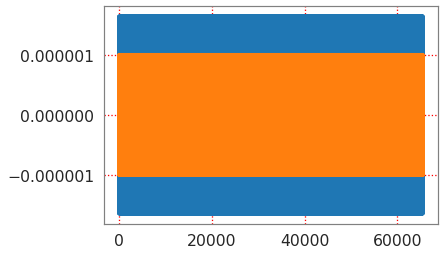

In [26]:
plt.plot(rec_x)
plt.plot(rec_y)

(0, 100)

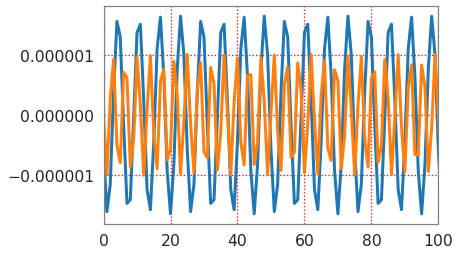

In [28]:
plt.plot(rec_x)
plt.plot(rec_y)
plt.xlim(0, 100)

Are the tunes correct? Let's compare to the `MAD-X` Twiss results:

In [29]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

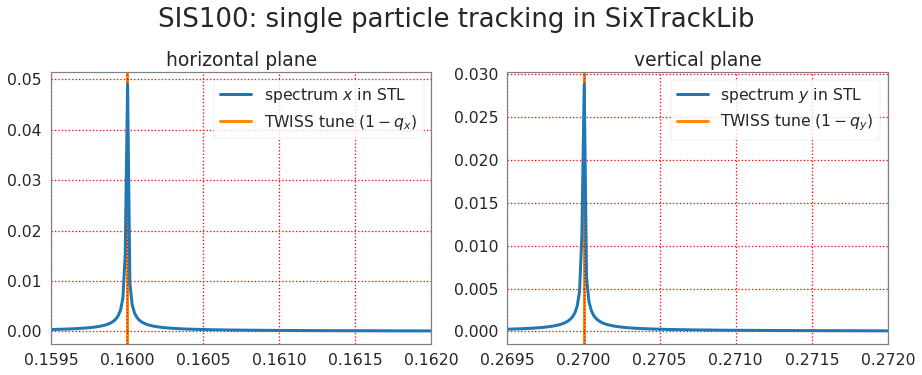

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x)),
    np.abs(np.fft.rfft(rec_x)),
    label=r'spectrum $x$ in STL'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.0005, qx + 0.002)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y)),
    np.abs(np.fft.rfft(rec_y)),
    label=r'spectrum $y$ in STL'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.0005, qy + 0.002)
plt.legend()

plt.suptitle('SIS100: single particle tracking in SixTrackLib', y=1.06, fontsize=26)
plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')

$\implies$ spot on! :-)

Have fun!

October 2019, Adrian